In [203]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate
import warnings
from tqdm import tqdm
import qriemannopt as qro

In [204]:
@tf.function
def renorm(U, Z, h):
    """the function renormalize local operation. As an input
    it takes disentangler, isometry and local operator.
    --------------------------------------------------------
    U.shape = (chi ** 2, chi ** 2)
    Z.shape = (chi ** 3, chi_new)
    returns tensor of shape (chi_new, chi_new, chi_new, chi_new)"""
    # U and Z reshaping
    chi = tf.cast(tf.math.sqrt(tf.cast(U.shape[0], dtype=tf.float64)), dtype=tf.int32)
    chi_new = Z.shape[-1]
    U_resh = tf.reshape(U, (chi, chi, chi, chi))
    Z_resh = tf.reshape(Z, (chi, chi, chi, chi_new))
    # applying disentangler
    uhu_up = tf.einsum('jmqr,ijkl,lmnp->iqrknp', tf.math.conj(U_resh), h, U_resh)
    uhu_mid = tf.einsum('ijnm,ijkl,klqp->nmqp', tf.math.conj(U_resh), h, U_resh)
    uhu_down = tf.einsum('minr,ijlk,mlqp->nrjqpk', tf.math.conj(U_resh), h, U_resh)
    # applying isometries
    z_up = tf.einsum('ijmn,ijkl->nmlk', tf.math.conj(Z_resh), Z_resh)
    z_down = tf.einsum('ijmn,kjml->nilk', tf.math.conj(Z_resh), Z_resh)
    aux_up = tf.einsum('qijp,ijklmn,qlmo->pkon', tf.math.conj(Z_resh), uhu_up, Z_resh)
    h_up = tf.einsum('ijkl,pjql->ipkq', aux_up, z_down)
    aux_down = tf.einsum('jkqp,ijklmn,mnqr->iplr', tf.math.conj(Z_resh), uhu_down, Z_resh)
    h_down = tf.einsum('ijkl,jqlp->iqkp', z_up, aux_down)
    # total renormalized hamiltonian
    h_mid = tf.einsum('ijkl,jqlm,rqom->irko', z_up, uhu_mid, z_down)
    return (1 / 3) * (h_up + h_mid + h_down)

@tf.function
def z_gen(inp, out):
    """the function generates random isometry.
    As an input it takes input dimension of input
    and output dimension
    ---------------------------------------------
    inp -- int number
    out -- int number
    returns tensor of shape (inp ** 3, out)"""
    Z = tf.cast(tf.random.normal((inp ** 3, inp ** 3)), dtype=tf.complex128) +\
    1j * tf.cast(tf.random.normal((inp ** 3, inp ** 3)), dtype=tf.complex128)
    Z, _ = tf.linalg.qr(Z)
    Z = Z[:, :out]
    return Z

@tf.function
def u_gen(dim):
    """the function generates random unitary
    matrix. As an input it takes dimension of
    one index.
    ----------------------------------------
    dim - int number
    returns tensor of shape (dim ** 2, dim ** 2)"""
    U = tf.cast(tf.random.normal((dim ** 2, dim ** 2)), dtype=tf.complex128) +\
    1j * tf.cast(tf.random.normal((dim ** 2, dim ** 2)), dtype=tf.complex128)
    U, _ = tf.linalg.qr(U)
    return U

In [205]:
# pauli matrices
sigma = tf.constant([[[1j*0, 1 + 1j*0], [1 + 1j*0, 0*1j]],
                    [[0*1j, -1j], [1j, 0*1j]],
                    [[1 + 0*1j, 0*1j], [0*1j, -1 + 0*1j]]],dtype=tf.complex128)

#########################################
# parameters
max_chi = 4 # maximal value of chi
num_of_layers = 5 # number of MERA layers
h_x = 1. # transvers magnetic field
#########################################

# random unitary and isometyric matrices
U = u_gen(2)
Z = z_gen(2, max_chi)
list_of_U = [u_gen(max_chi) for _ in range(num_of_layers - 1)]
list_of_Z = [z_gen(max_chi, max_chi) for _ in range(num_of_layers - 1)]
list_of_U = [U] + list_of_U
list_of_Z = [Z] + list_of_Z
psi = tf.cast(tf.random.normal((max_chi ** 2, 1)), dtype=tf.complex128) +\
                    1j * tf.cast(tf.random.normal((max_chi ** 2, 1)), dtype=tf.complex128)
psi = psi / (tf.math.sqrt(tf.linalg.adjoint(psi) @ psi)[0, 0])

# real variables
list_of_U_re = [tf.Variable(qro.manifold.complex_to_real(list_of_U[i])) for i in range(len(list_of_U))]
list_of_Z_re = [tf.Variable(qro.manifold.complex_to_real(list_of_Z[i])) for i in range(len(list_of_Z))]
psi_re = tf.Variable(qro.manifold.complex_to_real(psi))

In [206]:
# exact value of energy in critical point
N = 2 * (num_of_layers ** 2)
E0_exact_fin = -2 * (1 / np.sin(np.pi / (2 * N))) / N
print("E_exact = fin=", E0_exact_fin)

g = h_x
f = lambda k,g : -2*np.sqrt(1+g**2-2*g*np.cos(k))/np.pi/2.
E0_exact = integrate.quad(f, 0, np.pi, args=(g,))[0]
print("E_exact =", E0_exact)

E_exact = fin= -1.273449008363905
E_exact = -1.2732395447351623


In [199]:
#lr_in = 0.0. # learning rate in
#lr_out = 0.2 # learning rate out
lr = 0.01
num_of_iter = 2000 # number of iterations
#decay_coef = (lr_out / lr_in) ** (1 / 2000) # decay coefficient
opt = qro.optimizers.RAdam(m, lr_i, 0.9, ams=True)
#opt1 = qro.optimizers.RAdam(m, 0.03)
list_of_E = []
# hamiltonian
h = -tf.einsum('ij,kl->ikjl', sigma[2], sigma[2]) +\
tf.einsum('ij,kl->ikjl', -h_x * sigma[0] / 2, tf.eye(2, dtype=tf.complex128)) +\
tf.einsum('ij,kl->ikjl', -tf.eye(2, dtype=tf.complex128), h_x * sigma[0] / 2)
'''local_energy = tf.cast(tf.linalg.eigvalsh(tf.reshape(h, (4, 4)))[0], dtype=tf.float64)'''
for j in tqdm(range(1, num_of_iter)):
    
    '''lr = lr * decay_coef'''
    
    # gradient calculation
    with tf.GradientTape(persistent=True) as tape:
        
        # complex matrices
        list_of_U = [qro.manifold.real_to_complex(list_of_U_re[i]) for i in range(len(list_of_U_re))]
        list_of_Z = [qro.manifold.real_to_complex(list_of_Z_re[i]) for i in range(len(list_of_Z_re))]
        psi = qro.manifold.real_to_complex(psi_re)
        
        h_renorm = h
        # applying renormalization
        for i in range(len(list_of_U)):
            h_renorm = renorm(list_of_U[i], list_of_Z[i], h_renorm)
        # renormalizad hamiltonian
        h_renorm = tf.reshape(h_renorm, (max_chi * max_chi, max_chi * max_chi))
        # energy
        E = tf.cast((tf.linalg.adjoint(psi) @ h_renorm @ psi),
                    dtype=tf.float64)[0, 0]
        # adding curent value of energy
        list_of_E.append(E)
        
    # real gradients
    grad_u = tape.gradient(E, list_of_U_re)
    grad_z = tape.gradient(E, list_of_Z_re)
    grad_psi = tape.gradient(E, psi_re)
    del(tape)
    opt.apply_gradients(zip(grad_u + grad_z + [grad_psi], list_of_U_re + list_of_Z_re + [psi_re]))
    #opt.learning_rate.assign(opt.learning_rate * decay_coef)



  0%|                                                                                         | 0/1999 [00:00<?, ?it/s]

  0%|                                                                                 | 1/1999 [00:00<04:34,  7.27it/s]

  0%|                                                                                 | 2/1999 [00:00<04:13,  7.88it/s]

  0%|                                                                                 | 3/1999 [00:00<03:59,  8.34it/s]

  0%|▏                                                                                | 4/1999 [00:00<03:50,  8.65it/s]

  0%|▏                                                                                | 5/1999 [00:00<03:43,  8.92it/s]

  0%|▏                                                                                | 6/1999 [00:00<03:37,  9.15it/s]

  0%|▎                                                                                | 7/1999 [00:00<03:33,  9.35it/s]

  0%|▎                        

  3%|██▊                                                                             | 69/1999 [00:07<03:18,  9.73it/s]

  4%|██▊                                                                             | 70/1999 [00:07<03:20,  9.62it/s]

  4%|██▊                                                                             | 71/1999 [00:07<03:19,  9.66it/s]

  4%|██▉                                                                             | 72/1999 [00:07<03:17,  9.74it/s]

  4%|██▉                                                                             | 73/1999 [00:07<03:17,  9.76it/s]

  4%|██▉                                                                             | 74/1999 [00:07<03:17,  9.73it/s]

  4%|███                                                                             | 75/1999 [00:07<03:18,  9.67it/s]

  4%|███                                                                             | 76/1999 [00:07<03:19,  9.66it/s]

  4%|███                        

  7%|█████▍                                                                         | 139/1999 [00:14<03:18,  9.36it/s]

  7%|█████▌                                                                         | 140/1999 [00:14<03:21,  9.21it/s]

  7%|█████▌                                                                         | 141/1999 [00:14<03:17,  9.41it/s]

  7%|█████▌                                                                         | 142/1999 [00:14<03:15,  9.51it/s]

  7%|█████▋                                                                         | 143/1999 [00:14<03:13,  9.57it/s]

  7%|█████▋                                                                         | 144/1999 [00:15<03:14,  9.54it/s]

  7%|█████▋                                                                         | 145/1999 [00:15<03:13,  9.57it/s]

  7%|█████▊                                                                         | 147/1999 [00:15<03:10,  9.75it/s]

  7%|█████▊                     

 10%|████████▏                                                                      | 208/1999 [00:21<03:05,  9.66it/s]

 10%|████████▎                                                                      | 209/1999 [00:21<03:05,  9.65it/s]

 11%|████████▎                                                                      | 210/1999 [00:21<03:05,  9.65it/s]

 11%|████████▎                                                                      | 211/1999 [00:22<03:04,  9.70it/s]

 11%|████████▍                                                                      | 212/1999 [00:22<03:04,  9.68it/s]

 11%|████████▍                                                                      | 213/1999 [00:22<03:04,  9.67it/s]

 11%|████████▍                                                                      | 214/1999 [00:22<03:03,  9.72it/s]

 11%|████████▍                                                                      | 215/1999 [00:22<03:04,  9.70it/s]

 11%|████████▌                  

 14%|██████████▊                                                                    | 275/1999 [00:28<02:59,  9.61it/s]

 14%|██████████▉                                                                    | 276/1999 [00:28<03:00,  9.57it/s]

 14%|██████████▉                                                                    | 277/1999 [00:28<02:59,  9.59it/s]

 14%|██████████▉                                                                    | 278/1999 [00:28<02:58,  9.66it/s]

 14%|███████████                                                                    | 279/1999 [00:29<02:59,  9.57it/s]

 14%|███████████                                                                    | 280/1999 [00:29<02:58,  9.65it/s]

 14%|███████████                                                                    | 281/1999 [00:29<02:57,  9.67it/s]

 14%|███████████▏                                                                   | 282/1999 [00:29<02:57,  9.66it/s]

 14%|███████████▏               

 17%|█████████████▌                                                                 | 342/1999 [00:35<02:50,  9.72it/s]

 17%|█████████████▌                                                                 | 343/1999 [00:35<02:51,  9.67it/s]

 17%|█████████████▌                                                                 | 344/1999 [00:35<02:51,  9.63it/s]

 17%|█████████████▋                                                                 | 345/1999 [00:35<02:51,  9.66it/s]

 17%|█████████████▋                                                                 | 346/1999 [00:35<02:51,  9.66it/s]

 17%|█████████████▋                                                                 | 347/1999 [00:36<02:50,  9.71it/s]

 17%|█████████████▊                                                                 | 348/1999 [00:36<02:50,  9.69it/s]

 17%|█████████████▊                                                                 | 349/1999 [00:36<02:50,  9.67it/s]

 18%|█████████████▊             

 20%|████████████████▏                                                              | 409/1999 [00:42<02:44,  9.65it/s]

 21%|████████████████▏                                                              | 410/1999 [00:42<02:44,  9.65it/s]

 21%|████████████████▏                                                              | 411/1999 [00:42<02:43,  9.70it/s]

 21%|████████████████▎                                                              | 412/1999 [00:42<02:44,  9.65it/s]

 21%|████████████████▎                                                              | 413/1999 [00:42<02:43,  9.68it/s]

 21%|████████████████▎                                                              | 414/1999 [00:43<02:43,  9.70it/s]

 21%|████████████████▍                                                              | 415/1999 [00:43<02:44,  9.65it/s]

 21%|████████████████▍                                                              | 416/1999 [00:43<02:43,  9.68it/s]

 21%|████████████████▍          

 24%|██████████████████▊                                                            | 476/1999 [00:49<02:36,  9.72it/s]

 24%|██████████████████▊                                                            | 477/1999 [00:49<02:37,  9.67it/s]

 24%|██████████████████▉                                                            | 478/1999 [00:49<02:37,  9.66it/s]

 24%|██████████████████▉                                                            | 479/1999 [00:49<02:36,  9.68it/s]

 24%|██████████████████▉                                                            | 480/1999 [00:49<02:37,  9.67it/s]

 24%|███████████████████                                                            | 481/1999 [00:49<02:36,  9.72it/s]

 24%|███████████████████                                                            | 482/1999 [00:50<02:36,  9.69it/s]

 24%|███████████████████                                                            | 483/1999 [00:50<02:36,  9.68it/s]

 24%|███████████████████▏       

 27%|█████████████████████▍                                                         | 543/1999 [00:56<02:30,  9.67it/s]

 27%|█████████████████████▍                                                         | 544/1999 [00:56<02:30,  9.69it/s]

 27%|█████████████████████▌                                                         | 545/1999 [00:56<02:30,  9.67it/s]

 27%|█████████████████████▌                                                         | 546/1999 [00:56<02:31,  9.61it/s]

 27%|█████████████████████▌                                                         | 547/1999 [00:56<02:30,  9.65it/s]

 27%|█████████████████████▋                                                         | 548/1999 [00:56<02:30,  9.67it/s]

 27%|█████████████████████▋                                                         | 549/1999 [00:56<02:29,  9.69it/s]

 28%|█████████████████████▋                                                         | 550/1999 [00:57<02:29,  9.70it/s]

 28%|█████████████████████▊     

 31%|████████████████████████                                                       | 610/1999 [01:03<02:24,  9.63it/s]

 31%|████████████████████████▏                                                      | 611/1999 [01:03<02:24,  9.63it/s]

 31%|████████████████████████▏                                                      | 612/1999 [01:03<02:23,  9.64it/s]

 31%|████████████████████████▏                                                      | 613/1999 [01:03<02:22,  9.69it/s]

 31%|████████████████████████▎                                                      | 614/1999 [01:03<02:23,  9.68it/s]

 31%|████████████████████████▎                                                      | 615/1999 [01:03<02:22,  9.69it/s]

 31%|████████████████████████▎                                                      | 616/1999 [01:03<02:22,  9.73it/s]

 31%|████████████████████████▍                                                      | 617/1999 [01:04<02:22,  9.71it/s]

 31%|████████████████████████▍  

 34%|██████████████████████████▊                                                    | 677/1999 [01:10<02:16,  9.70it/s]

 34%|██████████████████████████▊                                                    | 678/1999 [01:10<02:16,  9.68it/s]

 34%|██████████████████████████▊                                                    | 679/1999 [01:10<02:16,  9.64it/s]

 34%|██████████████████████████▊                                                    | 680/1999 [01:10<02:15,  9.72it/s]

 34%|██████████████████████████▉                                                    | 681/1999 [01:10<02:15,  9.76it/s]

 34%|██████████████████████████▉                                                    | 682/1999 [01:10<02:15,  9.69it/s]

 34%|██████████████████████████▉                                                    | 683/1999 [01:10<02:17,  9.59it/s]

 34%|███████████████████████████                                                    | 684/1999 [01:11<02:16,  9.61it/s]

 34%|███████████████████████████

 37%|█████████████████████████████▍                                                 | 744/1999 [01:17<02:09,  9.66it/s]

 37%|█████████████████████████████▍                                                 | 745/1999 [01:17<02:09,  9.66it/s]

 37%|█████████████████████████████▍                                                 | 746/1999 [01:17<02:09,  9.71it/s]

 37%|█████████████████████████████▌                                                 | 747/1999 [01:17<02:08,  9.72it/s]

 37%|█████████████████████████████▌                                                 | 748/1999 [01:17<02:08,  9.72it/s]

 37%|█████████████████████████████▌                                                 | 749/1999 [01:17<02:08,  9.75it/s]

 38%|█████████████████████████████▋                                                 | 750/1999 [01:17<02:07,  9.78it/s]

 38%|█████████████████████████████▋                                                 | 751/1999 [01:17<02:08,  9.68it/s]

 38%|███████████████████████████

 41%|████████████████████████████████                                               | 811/1999 [01:24<02:04,  9.57it/s]

 41%|████████████████████████████████                                               | 812/1999 [01:24<02:03,  9.65it/s]

 41%|████████████████████████████████▏                                              | 813/1999 [01:24<02:02,  9.65it/s]

 41%|████████████████████████████████▏                                              | 814/1999 [01:24<02:02,  9.67it/s]

 41%|████████████████████████████████▏                                              | 815/1999 [01:24<02:01,  9.72it/s]

 41%|████████████████████████████████▏                                              | 816/1999 [01:24<02:02,  9.64it/s]

 41%|████████████████████████████████▎                                              | 818/1999 [01:24<02:00,  9.82it/s]

 41%|████████████████████████████████▎                                              | 819/1999 [01:24<02:00,  9.77it/s]

 41%|███████████████████████████

 44%|██████████████████████████████████▋                                            | 879/1999 [01:31<01:56,  9.60it/s]

 44%|██████████████████████████████████▊                                            | 880/1999 [01:31<01:55,  9.67it/s]

 44%|██████████████████████████████████▊                                            | 881/1999 [01:31<01:55,  9.69it/s]

 44%|██████████████████████████████████▊                                            | 882/1999 [01:31<01:55,  9.67it/s]

 44%|██████████████████████████████████▉                                            | 883/1999 [01:31<01:55,  9.66it/s]

 44%|██████████████████████████████████▉                                            | 884/1999 [01:31<01:55,  9.66it/s]

 44%|██████████████████████████████████▉                                            | 885/1999 [01:31<01:55,  9.68it/s]

 44%|███████████████████████████████████                                            | 886/1999 [01:31<01:54,  9.70it/s]

 44%|███████████████████████████

 47%|█████████████████████████████████████▍                                         | 947/1999 [01:38<01:48,  9.67it/s]

 47%|█████████████████████████████████████▍                                         | 948/1999 [01:38<01:48,  9.72it/s]

 47%|█████████████████████████████████████▌                                         | 949/1999 [01:38<01:48,  9.67it/s]

 48%|█████████████████████████████████████▌                                         | 950/1999 [01:38<01:48,  9.69it/s]

 48%|█████████████████████████████████████▌                                         | 951/1999 [01:38<01:47,  9.73it/s]

 48%|█████████████████████████████████████▌                                         | 952/1999 [01:38<01:47,  9.73it/s]

 48%|█████████████████████████████████████▋                                         | 953/1999 [01:38<01:47,  9.70it/s]

 48%|█████████████████████████████████████▋                                         | 954/1999 [01:38<01:47,  9.68it/s]

 48%|███████████████████████████

 51%|███████████████████████████████████████▌                                      | 1015/1999 [01:45<01:41,  9.70it/s]

 51%|███████████████████████████████████████▋                                      | 1016/1999 [01:45<01:42,  9.60it/s]

 51%|███████████████████████████████████████▋                                      | 1017/1999 [01:45<01:41,  9.64it/s]

 51%|███████████████████████████████████████▋                                      | 1018/1999 [01:45<01:41,  9.64it/s]

 51%|███████████████████████████████████████▊                                      | 1019/1999 [01:45<01:41,  9.61it/s]

 51%|███████████████████████████████████████▊                                      | 1020/1999 [01:45<01:41,  9.65it/s]

 51%|███████████████████████████████████████▊                                      | 1021/1999 [01:45<01:41,  9.62it/s]

 51%|███████████████████████████████████████▉                                      | 1022/1999 [01:45<01:41,  9.65it/s]

 51%|███████████████████████████

 54%|██████████████████████████████████████████▎                                   | 1083/1999 [01:52<01:35,  9.63it/s]

 54%|██████████████████████████████████████████▎                                   | 1084/1999 [01:52<01:34,  9.63it/s]

 54%|██████████████████████████████████████████▎                                   | 1085/1999 [01:52<01:34,  9.64it/s]

 54%|██████████████████████████████████████████▍                                   | 1086/1999 [01:52<01:34,  9.64it/s]

 54%|██████████████████████████████████████████▍                                   | 1087/1999 [01:52<01:34,  9.64it/s]

 54%|██████████████████████████████████████████▍                                   | 1088/1999 [01:52<01:35,  9.58it/s]

 54%|██████████████████████████████████████████▍                                   | 1089/1999 [01:52<01:34,  9.63it/s]

 55%|██████████████████████████████████████████▌                                   | 1090/1999 [01:53<01:34,  9.60it/s]

 55%|███████████████████████████

 58%|████████████████████████████████████████████▊                                 | 1150/1999 [01:59<01:28,  9.64it/s]

 58%|████████████████████████████████████████████▉                                 | 1151/1999 [01:59<01:27,  9.64it/s]

 58%|████████████████████████████████████████████▉                                 | 1152/1999 [01:59<01:27,  9.67it/s]

 58%|████████████████████████████████████████████▉                                 | 1153/1999 [01:59<01:27,  9.66it/s]

 58%|█████████████████████████████████████████████                                 | 1154/1999 [01:59<01:28,  9.60it/s]

 58%|█████████████████████████████████████████████                                 | 1155/1999 [01:59<01:27,  9.67it/s]

 58%|█████████████████████████████████████████████                                 | 1156/1999 [01:59<01:27,  9.66it/s]

 58%|█████████████████████████████████████████████▏                                | 1157/1999 [01:59<01:27,  9.65it/s]

 58%|███████████████████████████

 61%|███████████████████████████████████████████████▍                              | 1217/1999 [02:06<01:21,  9.60it/s]

 61%|███████████████████████████████████████████████▌                              | 1218/1999 [02:06<01:21,  9.61it/s]

 61%|███████████████████████████████████████████████▌                              | 1219/1999 [02:06<01:20,  9.68it/s]

 61%|███████████████████████████████████████████████▌                              | 1220/1999 [02:06<01:20,  9.66it/s]

 61%|███████████████████████████████████████████████▋                              | 1221/1999 [02:06<01:21,  9.60it/s]

 61%|███████████████████████████████████████████████▋                              | 1222/1999 [02:06<01:21,  9.59it/s]

 61%|███████████████████████████████████████████████▋                              | 1223/1999 [02:06<01:20,  9.66it/s]

 61%|███████████████████████████████████████████████▊                              | 1224/1999 [02:06<01:20,  9.68it/s]

 61%|███████████████████████████

 64%|██████████████████████████████████████████████████                            | 1284/1999 [02:13<01:13,  9.70it/s]

 64%|██████████████████████████████████████████████████▏                           | 1285/1999 [02:13<01:13,  9.71it/s]

 64%|██████████████████████████████████████████████████▏                           | 1286/1999 [02:13<01:13,  9.72it/s]

 64%|██████████████████████████████████████████████████▏                           | 1287/1999 [02:13<01:13,  9.72it/s]

 64%|██████████████████████████████████████████████████▎                           | 1288/1999 [02:13<01:13,  9.70it/s]

 64%|██████████████████████████████████████████████████▎                           | 1289/1999 [02:13<01:12,  9.74it/s]

 65%|██████████████████████████████████████████████████▎                           | 1290/1999 [02:13<01:13,  9.68it/s]

 65%|██████████████████████████████████████████████████▎                           | 1291/1999 [02:13<01:12,  9.72it/s]

 65%|███████████████████████████

 68%|████████████████████████████████████████████████████▋                         | 1351/1999 [02:20<01:07,  9.63it/s]

 68%|████████████████████████████████████████████████████▊                         | 1352/1999 [02:20<01:06,  9.66it/s]

 68%|████████████████████████████████████████████████████▊                         | 1353/1999 [02:20<01:06,  9.66it/s]

 68%|████████████████████████████████████████████████████▊                         | 1354/1999 [02:20<01:07,  9.57it/s]

 68%|████████████████████████████████████████████████████▊                         | 1355/1999 [02:20<01:07,  9.56it/s]

 68%|████████████████████████████████████████████████████▉                         | 1356/1999 [02:20<01:06,  9.61it/s]

 68%|████████████████████████████████████████████████████▉                         | 1357/1999 [02:20<01:07,  9.51it/s]

 68%|████████████████████████████████████████████████████▉                         | 1358/1999 [02:20<01:07,  9.55it/s]

 68%|███████████████████████████

 71%|███████████████████████████████████████████████████████▎                      | 1418/1999 [02:27<01:00,  9.61it/s]

 71%|███████████████████████████████████████████████████████▎                      | 1419/1999 [02:27<01:00,  9.65it/s]

 71%|███████████████████████████████████████████████████████▍                      | 1420/1999 [02:27<01:00,  9.62it/s]

 71%|███████████████████████████████████████████████████████▍                      | 1421/1999 [02:27<00:59,  9.65it/s]

 71%|███████████████████████████████████████████████████████▍                      | 1422/1999 [02:27<00:59,  9.71it/s]

 71%|███████████████████████████████████████████████████████▌                      | 1423/1999 [02:27<00:59,  9.74it/s]

 71%|███████████████████████████████████████████████████████▌                      | 1424/1999 [02:27<00:58,  9.77it/s]

 71%|███████████████████████████████████████████████████████▌                      | 1425/1999 [02:27<00:59,  9.65it/s]

 71%|███████████████████████████

 74%|█████████████████████████████████████████████████████████▉                    | 1486/1999 [02:34<00:52,  9.70it/s]

 74%|██████████████████████████████████████████████████████████                    | 1487/1999 [02:34<00:52,  9.74it/s]

 74%|██████████████████████████████████████████████████████████                    | 1488/1999 [02:34<00:52,  9.77it/s]

 74%|██████████████████████████████████████████████████████████                    | 1489/1999 [02:34<00:52,  9.70it/s]

 75%|██████████████████████████████████████████████████████████▏                   | 1490/1999 [02:34<00:52,  9.71it/s]

 75%|██████████████████████████████████████████████████████████▏                   | 1491/1999 [02:34<00:52,  9.69it/s]

 75%|██████████████████████████████████████████████████████████▏                   | 1492/1999 [02:34<00:52,  9.65it/s]

 75%|██████████████████████████████████████████████████████████▎                   | 1493/1999 [02:34<00:52,  9.65it/s]

 75%|███████████████████████████

 78%|████████████████████████████████████████████████████████████▌                 | 1553/1999 [02:40<00:46,  9.60it/s]

 78%|████████████████████████████████████████████████████████████▋                 | 1554/1999 [02:41<00:46,  9.61it/s]

 78%|████████████████████████████████████████████████████████████▋                 | 1555/1999 [02:41<00:46,  9.65it/s]

 78%|████████████████████████████████████████████████████████████▋                 | 1556/1999 [02:41<00:45,  9.65it/s]

 78%|████████████████████████████████████████████████████████████▊                 | 1557/1999 [02:41<00:45,  9.64it/s]

 78%|████████████████████████████████████████████████████████████▊                 | 1558/1999 [02:41<00:45,  9.64it/s]

 78%|████████████████████████████████████████████████████████████▊                 | 1559/1999 [02:41<00:45,  9.64it/s]

 78%|████████████████████████████████████████████████████████████▊                 | 1560/1999 [02:41<00:45,  9.67it/s]

 78%|███████████████████████████

 81%|███████████████████████████████████████████████████████████████▏              | 1620/1999 [02:47<00:39,  9.68it/s]

 81%|███████████████████████████████████████████████████████████████▎              | 1621/1999 [02:48<00:38,  9.70it/s]

 81%|███████████████████████████████████████████████████████████████▎              | 1622/1999 [02:48<00:38,  9.74it/s]

 81%|███████████████████████████████████████████████████████████████▎              | 1623/1999 [02:48<00:38,  9.77it/s]

 81%|███████████████████████████████████████████████████████████████▎              | 1624/1999 [02:48<00:38,  9.73it/s]

 81%|███████████████████████████████████████████████████████████████▍              | 1625/1999 [02:48<00:38,  9.65it/s]

 81%|███████████████████████████████████████████████████████████████▍              | 1626/1999 [02:48<00:38,  9.62it/s]

 81%|███████████████████████████████████████████████████████████████▍              | 1627/1999 [02:48<00:38,  9.68it/s]

 81%|███████████████████████████

 84%|█████████████████████████████████████████████████████████████████▊            | 1687/1999 [02:54<00:32,  9.64it/s]

 84%|█████████████████████████████████████████████████████████████████▊            | 1688/1999 [02:54<00:32,  9.64it/s]

 84%|█████████████████████████████████████████████████████████████████▉            | 1689/1999 [02:55<00:32,  9.67it/s]

 85%|█████████████████████████████████████████████████████████████████▉            | 1690/1999 [02:55<00:31,  9.69it/s]

 85%|█████████████████████████████████████████████████████████████████▉            | 1691/1999 [02:55<00:31,  9.73it/s]

 85%|██████████████████████████████████████████████████████████████████            | 1692/1999 [02:55<00:31,  9.73it/s]

 85%|██████████████████████████████████████████████████████████████████            | 1693/1999 [02:55<00:31,  9.68it/s]

 85%|██████████████████████████████████████████████████████████████████            | 1694/1999 [02:55<00:31,  9.72it/s]

 85%|███████████████████████████

 88%|████████████████████████████████████████████████████████████████████▍         | 1754/1999 [03:01<00:25,  9.58it/s]

 88%|████████████████████████████████████████████████████████████████████▍         | 1755/1999 [03:01<00:25,  9.60it/s]

 88%|████████████████████████████████████████████████████████████████████▌         | 1756/1999 [03:01<00:25,  9.67it/s]

 88%|████████████████████████████████████████████████████████████████████▌         | 1757/1999 [03:02<00:24,  9.69it/s]

 88%|████████████████████████████████████████████████████████████████████▌         | 1758/1999 [03:02<00:25,  9.56it/s]

 88%|████████████████████████████████████████████████████████████████████▋         | 1759/1999 [03:02<00:25,  9.59it/s]

 88%|████████████████████████████████████████████████████████████████████▋         | 1760/1999 [03:02<00:24,  9.63it/s]

 88%|████████████████████████████████████████████████████████████████████▋         | 1761/1999 [03:02<00:24,  9.66it/s]

 88%|███████████████████████████

 91%|███████████████████████████████████████████████████████████████████████       | 1821/1999 [03:08<00:18,  9.59it/s]

 91%|███████████████████████████████████████████████████████████████████████       | 1822/1999 [03:08<00:18,  9.58it/s]

 91%|███████████████████████████████████████████████████████████████████████▏      | 1823/1999 [03:08<00:18,  9.62it/s]

 91%|███████████████████████████████████████████████████████████████████████▏      | 1824/1999 [03:09<00:18,  9.66it/s]

 91%|███████████████████████████████████████████████████████████████████████▏      | 1825/1999 [03:09<00:17,  9.68it/s]

 91%|███████████████████████████████████████████████████████████████████████▏      | 1826/1999 [03:09<00:17,  9.70it/s]

 91%|███████████████████████████████████████████████████████████████████████▎      | 1827/1999 [03:09<00:17,  9.68it/s]

 91%|███████████████████████████████████████████████████████████████████████▎      | 1828/1999 [03:09<00:17,  9.72it/s]

 91%|███████████████████████████

 94%|█████████████████████████████████████████████████████████████████████████▋    | 1888/1999 [03:15<00:11,  9.64it/s]

 94%|█████████████████████████████████████████████████████████████████████████▋    | 1889/1999 [03:15<00:11,  9.64it/s]

 95%|█████████████████████████████████████████████████████████████████████████▋    | 1890/1999 [03:15<00:11,  9.64it/s]

 95%|█████████████████████████████████████████████████████████████████████████▊    | 1891/1999 [03:16<00:11,  9.56it/s]

 95%|█████████████████████████████████████████████████████████████████████████▊    | 1892/1999 [03:16<00:11,  9.61it/s]

 95%|█████████████████████████████████████████████████████████████████████████▊    | 1893/1999 [03:16<00:11,  9.62it/s]

 95%|█████████████████████████████████████████████████████████████████████████▉    | 1894/1999 [03:16<00:10,  9.63it/s]

 95%|█████████████████████████████████████████████████████████████████████████▉    | 1895/1999 [03:16<00:10,  9.66it/s]

 95%|███████████████████████████

 98%|████████████████████████████████████████████████████████████████████████████▎ | 1955/1999 [03:22<00:04,  9.71it/s]

 98%|████████████████████████████████████████████████████████████████████████████▎ | 1956/1999 [03:22<00:04,  9.69it/s]

 98%|████████████████████████████████████████████████████████████████████████████▎ | 1957/1999 [03:22<00:04,  9.67it/s]

 98%|████████████████████████████████████████████████████████████████████████████▍ | 1958/1999 [03:22<00:04,  9.64it/s]

 98%|████████████████████████████████████████████████████████████████████████████▍ | 1959/1999 [03:23<00:04,  9.69it/s]

 98%|████████████████████████████████████████████████████████████████████████████▍ | 1960/1999 [03:23<00:04,  9.68it/s]

 98%|████████████████████████████████████████████████████████████████████████████▌ | 1961/1999 [03:23<00:03,  9.67it/s]

 98%|████████████████████████████████████████████████████████████████████████████▌ | 1962/1999 [03:23<00:03,  9.69it/s]

 98%|███████████████████████████

tf.Tensor(-1.2730094920732136, shape=(), dtype=float64)
-1.2732395447351623
-1.273449008363905


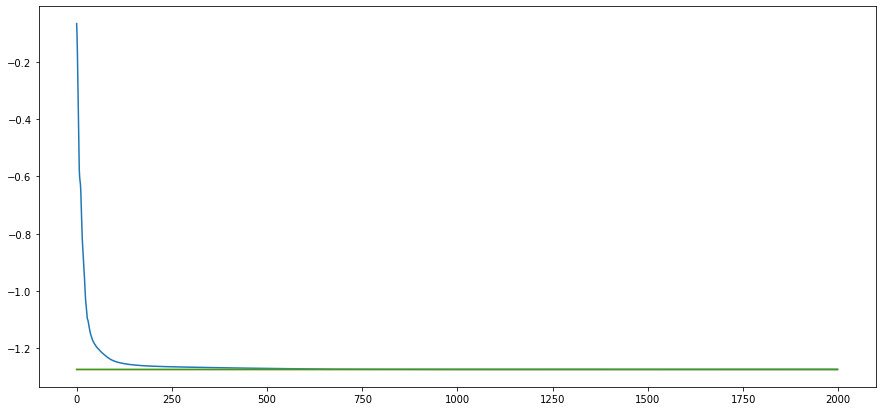

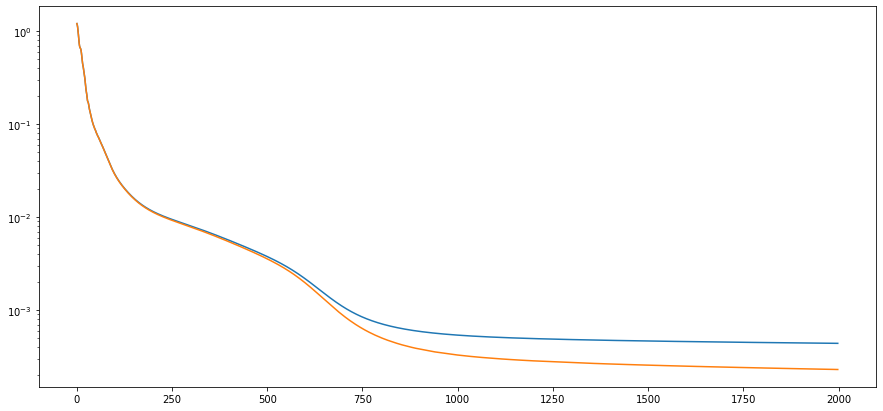

In [202]:
plt.figure(figsize=(15, 7))
plt.plot(list_of_E)
plt.plot([E0_exact] * len(list_of_E))
plt.plot([E0_exact_fin] * len(list_of_E))
plt.figure(figsize=(15, 7))
plt.yscale('log')
plt.plot(tf.math.abs(list_of_E - tf.convert_to_tensor(([E0_exact_fin] * len(list_of_E))), 'b'))
plt.plot(tf.math.abs(list_of_E - tf.convert_to_tensor(([E0_exact] * len(list_of_E))), 'b'))
print(list_of_E[-1])
print(E0_exact)
print(E0_exact_fin)

In [12]:
local_energy

<tf.Tensor: id=2223007, shape=(), dtype=complex128, numpy=(-1.4142135623730947+0j)>

In [30]:
grad_u[0]

<tf.Tensor: id=7861542, shape=(4, 4, 2), dtype=float64, numpy=
array([[[  0.13602239,   1.0660024 ],
        [ -0.65694634,   0.42560271],
        [ -3.72127885,  -0.84327752],
        [  0.18173942,  -1.09100822]],

       [[ -0.3594153 ,   0.89884788],
        [ -0.38660249,   0.17936607],
        [ -4.5922655 ,  -0.94162126],
        [ -0.02128266,  -0.88196925]],

       [[ -0.45541685,   0.80199619],
        [ -0.4478434 ,   0.17194328],
        [ -4.56984629,  -0.89432014],
        [  0.0437654 ,  -1.06782344]],

       [[ -2.02263941,   1.92515396],
        [ -0.80836801,   0.14366829],
        [-13.85595866,  -2.61209434],
        [ -0.2438044 ,  -2.40568112]]])>

In [40]:
grad_u[0]

<tf.Tensor: id=8984173, shape=(4, 4, 2), dtype=float64, numpy=
array([[[ 7.89317056,  5.90659595],
        [-4.97384155,  9.08628503],
        [-0.57932286, -2.19216577],
        [ 1.34530703, -0.67932217]],

       [[ 2.8184097 ,  1.94101468],
        [-1.63360546,  2.83247508],
        [-0.13858871, -1.0671787 ],
        [ 0.49862509, -0.1014295 ]],

       [[ 2.67272637,  1.90453604],
        [-1.61351394,  2.95243685],
        [-0.07084092, -1.08486907],
        [ 0.6450217 , -0.09175009]],

       [[ 2.45326092,  1.49417536],
        [-1.28693423,  2.16576977],
        [ 0.07240816, -1.55764383],
        [ 0.64573477,  0.15828425]]])>

In [64]:
opts[2].learning_rate

<tf.Variable 'RAdam/learning_rate:0' shape=() dtype=float32, numpy=0.01>

In [102]:
tf.cast(E - E0_exact_fin, dtype=tf.complex128)

<tf.Tensor: id=18017914, shape=(), dtype=complex128, numpy=(1.2358141254883714+0j)>

In [147]:
opt.learning_rate.assign(0.01)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=0.01>

In [148]:
opt.learning_rate

<tf.Variable 'RAdam/learning_rate:0' shape=() dtype=float32, numpy=0.01>